In [2]:
# Credit to https://www.kaggle.com/wfwiggins203 in https://www.kaggle.com/wfwiggins203/eda-dicom-tags-windowing-head-cts

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import re
import os
from pathlib import Path

plt.style.use('grayscale')


In [3]:
ROOT_DIR = "C:/Users/evbruh/Downloads/rsna-intracranial-hemorrhage-detection/"

In [4]:
TRAIN_DIR = ROOT_DIR + 'stage_1_train_images'
TEST_DIR = ROOT_DIR + 'stage_1_test_images'

In [5]:
train_df = pd.read_csv(ROOT_DIR + 'stage_1_train.csv')
print(train_df.shape)
train_df.head(10)

(4045572, 2)


,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0
5,ID_63eb1e259_any,0
6,ID_2669954a7_epidural,0
7,ID_2669954a7_intraparenchymal,0
8,ID_2669954a7_intraventricular,0
9,ID_2669954a7_subarachnoid,0


In [6]:
train_df[['ID', 'Subtype']] = train_df['ID'].str.rsplit(pat='_', n=1, expand=True)
print(train_df.shape)
train_df.head()

(4045572, 3)


,ID,Label,Subtype
0,ID_63eb1e259,0,epidural
1,ID_63eb1e259,0,intraparenchymal
2,ID_63eb1e259,0,intraventricular
3,ID_63eb1e259,0,subarachnoid
4,ID_63eb1e259,0,subdural


In [7]:
def fix_id(img_id, img_dir=TRAIN_DIR):
    if not re.match(r'ID_[a-z0-9]+', img_id):
        sop = re.search(r'[a-z0-9]+', img_id)
        if sop:
            img_id_new = f'ID_{sop[0]}'
            return img_id_new
        else:
            print(img_id)
    return img_id


In [1]:
# test
assert(fix_id('ID_63eb1e259') == fix_id('ID63eb1e259'))
test = 'ID_dbdedfada'
assert(fix_id(test) == 'ID_dbdedfada')

NameError: name 'fix_id' is not defined

In [9]:
train_df['ID'] = train_df['ID'].apply(fix_id)

In [10]:
# this method also handles duplicates gracefully
train_new = train_df.pivot_table(index='ID', columns='Subtype').reset_index()
print(train_new.shape)
train_new.head()

(674258, 7)


ID Label                                             \
Subtype                 any epidural intraparenchymal intraventricular   
0        ID_000039fa0     0        0                0                0   
1        ID_00005679d     0        0                0                0   
2        ID_00008ce3c     0        0                0                0   
3        ID_0000950d7     0        0                0                0   
4        ID_0000aee4b     0        0                0                0   

                               
Subtype subarachnoid subdural  
0                  0        0  
1                  0        0  
2                  0        0  
3                  0        0  
4                  0        0

In [11]:
subtype_ct = train_new['Label'].sum(axis=0)
print(subtype_ct)

Subtype
any                 97103
epidural             2761
intraparenchymal    32564
intraventricular    23766
subarachnoid        32122
subdural            42496
dtype: int64


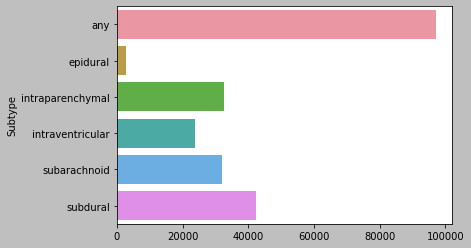

In [12]:
sns.barplot(x=subtype_ct.values, y=subtype_ct.index);

In [13]:
def id_to_filepath(img_id, img_dir=TRAIN_DIR):
    filepath = f'{img_dir}/{img_id}.dcm' # pydicom doesn't play nice with Path objects
    if os.path.exists(filepath):
        return filepath
    else:
        return 'DNE'

In [14]:
img_id = train_new['ID'][0]
img_filepath = id_to_filepath(img_id)
print(img_filepath)

C:/Users/evbruh/Downloads/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_000039fa0.dcm


In [15]:
train_new['filepath'] = train_new['ID'].apply(id_to_filepath)
train_new.head()

ID Label                                             \
Subtype                 any epidural intraparenchymal intraventricular   
0        ID_000039fa0     0        0                0                0   
1        ID_00005679d     0        0                0                0   
2        ID_00008ce3c     0        0                0                0   
3        ID_0000950d7     0        0                0                0   
4        ID_0000aee4b     0        0                0                0   

                               \
Subtype subarachnoid subdural   
0                  0        0   
1                  0        0   
2                  0        0   
3                  0        0   
4                  0        0   

                                                  filepath  
Subtype                                                     
0        C:/Users/evbruh/Downloads/rsna-intracranial-he...  
1        C:/Users/evbruh/Downloads/rsna-intracranial-he...  
2        C:/Users/evbruh/Downloads/rsna-intracranial-he...  
3        C:/Users/evbruh/Downloads/rsna-intracranial-he...  
4        C:/Users/evbruh/Downloads/rsna-intracranial-he...

In [17]:
dcm_data = pydicom.dcmread(img_filepath)
print(dcm_data)

(0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-141.318451', '62.720940']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.968148', '-0.250380']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

In [18]:
def get_patient_data(filepath):
    if filepath != 'DNE':
        dcm_data = pydicom.dcmread(filepath, stop_before_pixels=True)
        return dcm_data.PatientID, dcm_data.StudyInstanceUID, dcm_data.SeriesInstanceUID

In [19]:
patient, study, series = get_patient_data(img_filepath)
print(patient, study, series)

ID_eeaf99e7 ID_134d398b61 ID_5f8484c3e0


In [20]:
# quick test to make sure our df.apply syntax is working, since the next cell takes a long time to run
test = train_new[:5].copy()
test['PatientID'], test['StudyID'], test['SeriesID'] = zip(*test['filepath'].map(get_patient_data))
test.head()

ID Label                                             \
Subtype                 any epidural intraparenchymal intraventricular   
0        ID_000039fa0     0        0                0                0   
1        ID_00005679d     0        0                0                0   
2        ID_00008ce3c     0        0                0                0   
3        ID_0000950d7     0        0                0                0   
4        ID_0000aee4b     0        0                0                0   

                               \
Subtype subarachnoid subdural   
0                  0        0   
1                  0        0   
2                  0        0   
3                  0        0   
4                  0        0   

                                                  filepath    PatientID  \
Subtype                                                                   
0        C:/Users/evbruh/Downloads/rsna-intracranial-he...  ID_eeaf99e7   
1        C:/Users/evbruh/Downloads/rsna-intracranial-he...  ID_18f2d431   
2        C:/Users/evbruh/Downloads/rsna-intracranial-he...  ID_ce8a3cd2   
3        C:/Users/evbruh/Downloads/rsna-intracranial-he...  ID_d278c67b   
4        C:/Users/evbruh/Downloads/rsna-intracranial-he...  ID_ce5f0b6c   

               StudyID       SeriesID  
Subtype                                
0        ID_134d398b61  ID_5f8484c3e0  
1        ID_b5c26cda09  ID_203cd6ec46  
2        ID_974735bf79  ID_3780d48b28  
3        ID_8881b1c4b1  ID_84296c3845  
4        ID_9aad90e421  ID_1e59488a44

In [21]:
type(dcm_data.WindowWidth)

pydicom.valuerep.DSfloat

In [22]:
def window_img(dcm, width=None, level=None):
    pixels = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    if not width:
        width = dcm.WindowWidth
        if type(width) != pydicom.valuerep.DSfloat:
            width = width[0]
    if not level:
        level = dcm.WindowCenter
        if type(level) != pydicom.valuerep.DSfloat:
            level = level[0]
    lower = level - (width / 2)
    upper = level + (width / 2)
    return np.clip(pixels, lower, upper)

def load_one_image(idx, df=train_new, width=None, level=None):
    assert('filepath' in df.columns)
    dcm_data = pydicom.dcmread(df['filepath'][idx])
    pixels = window_img(dcm_data, width, level)
    return pixels

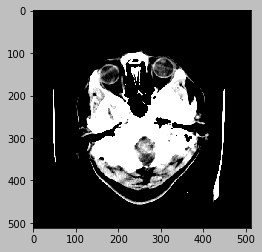

In [23]:
# standard brain window
pixels = load_one_image(0)
plt.imshow(pixels);

In [24]:
train_new.filepath.iloc[0]

'C:/Users/evbruh/Downloads/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_000039fa0.dcm'

In [25]:
hem_types = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']


def view_images(images):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        image = images[im]
        i = im // width
        j = im % width
        axs[i,j].imshow(image, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        title = hem_types[im] if im < len(hem_types) else 'normal'
        axs[i,j].set_title(title)

    plt.show()
    
def load_random_images():
    image_names = [list(train_new[train_new['Label', h_type] == 1].sample(1)['filepath'])[0] for h_type in hem_types]
    image_names += list(train_new[train_new['Label', 'any'] == 0].sample(5)['filepath'])
    return [pydicom.read_file(os.path.join(ROOT_DIR, img_name)) for img_name in image_names]

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [26]:
imgs = load_random_images()

In [27]:
print('DICOM Pixel Data Shape: ', imgs[0].pixel_array.shape)

DICOM Pixel Data Shape:  (512, 512)


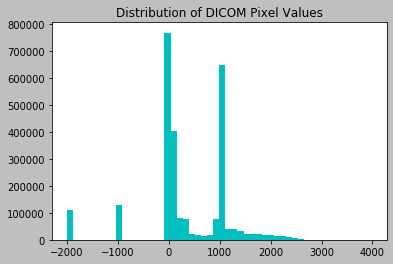

In [28]:
plt.title('Distribution of DICOM Pixel Values')
ax = plt.hist(np.array([img.pixel_array for img in imgs]).flatten(), bins=50, color='c')

### No Windowing

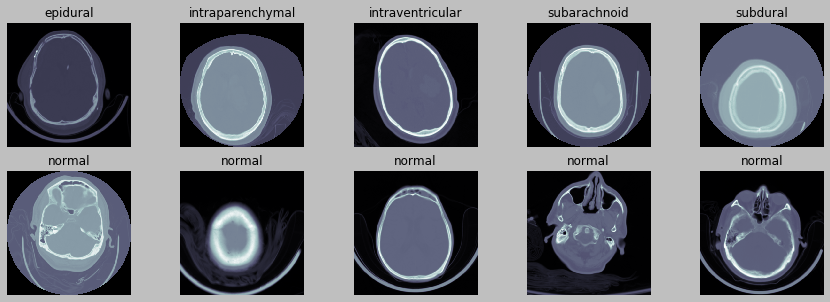

In [29]:
view_images([img.pixel_array for img in imgs])

### W/ Windowing

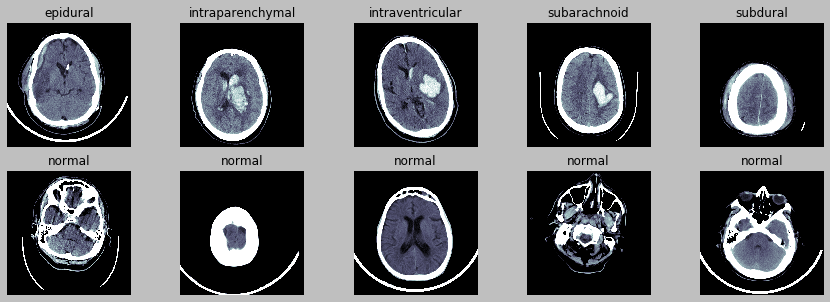

In [30]:
def brain_window(img):
    window_min = 0
    window_max = 80
    _, _, intercept, slope = get_windowing(img)
    img = img.pixel_array
    img = img * slope + intercept
    img[img < window_min] = window_min
    img[img > window_max] = window_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

view_images([brain_window(img) for img in imgs])

Metadata Window Ranges:
0 80
-35 115
0 80
-35 115
-10 70
-10 70
-4 76
-4 76
0 80
-4 76


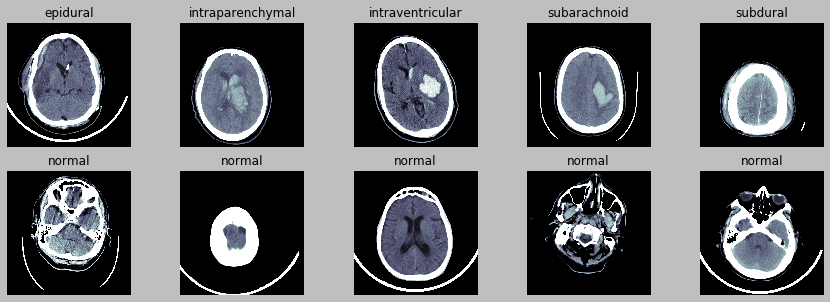

In [31]:
def metadata_window(img, print_ranges=True):
    # Get data from dcm
    window_center, window_width, intercept, slope = get_windowing(img)
    img = img.pixel_array
    
    # Window based on dcm metadata
    img = img * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    if print_ranges:
        print(img_min, img_max)
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    
    # Normalize
    img = (img - img_min) / (img_max - img_min)
    return img
    

print('Metadata Window Ranges:')
view_images([metadata_window(img) for img in imgs])

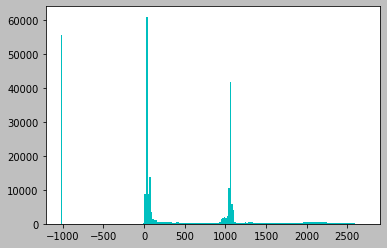

In [32]:
ax = plt.hist(np.array([imgs[3].pixel_array]).flatten(), bins=200, color='c')

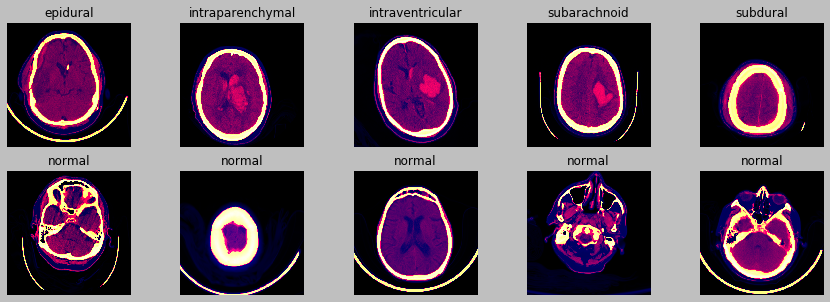

In [65]:
def window_image(img, window_center, window_width):
    _, _, intercept, slope = get_windowing(img)
    img = img.pixel_array * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def bsb_window(img):
    brain_img = window_image(img, 40, 80)
    subdural_img = window_image(img, 175, 50)
    bone_img = window_image(img, 500, 3000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

view_images([bsb_window(img) for img in imgs])

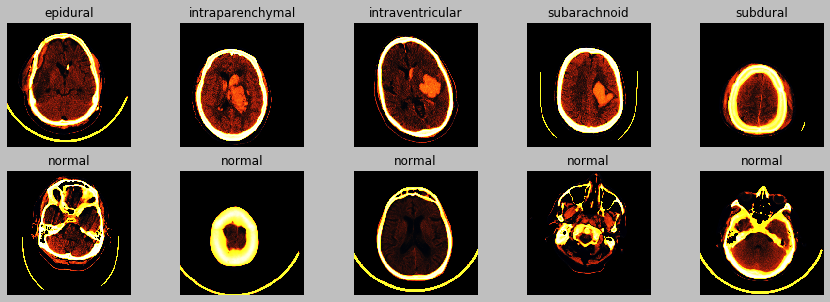

In [34]:
from math import log

def _normalize(x):
    x_max = x.max()
    x_min = x.min()
    if x_max != x_min:
        z = (x - x_min) / (x_max - x_min)
        return z
    return np.zeros(x.shape)

def sigmoid_window(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0), desired_size=(256, 256)):
    intercept, slope = img.RescaleIntercept, img.RescaleSlope
    img = img.pixel_array * slope + intercept
    
    # resizing already to save computation
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    ue = log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    
    img = _normalize(img)
    
    return img

def sigmoid_bsb_window(img, desired_size=(256, 256)):
    brain_img = sigmoid_window(img, 40, 80, desired_size=desired_size)
    subdural_img = sigmoid_window(img, 80, 200, desired_size=desired_size)
    bone_img = sigmoid_window(img, 600, 2000, desired_size=desired_size)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

view_images([sigmoid_bsb_window(img) for img in imgs])


### Neural Net Explore

In [35]:

import os
import sys
import random
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms


In [37]:
eg_img = sigmoid_bsb_window(imgs[0])

In [38]:
model = models.densenet121(pretrained=True)

C:\Users\evbruh\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [39]:
torch.cuda.empty_cache(), torch.cuda.memory_allocated()


(None, 0)

In [40]:
model_ft = nn.Sequential(*list(model.features)[:-1])
model_ft = model_ft.cuda()

In [43]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                     std=[0.229, 0.224, 0.225])
])


In [44]:
eg_tens = transform((255*eg_img).astype(np.uint8)).cuda()
eg_tens = eg_tens.view(1, 3, eg_tens.shape[1], eg_tens.shape[2])
eg_tens.shape, eg_tens.dtype, eg_tens.is_cuda, eg_tens.min(), eg_tens.max()

(torch.Size([1, 3, 256, 256]),
 torch.float32,
 True,
 tensor(-2.1179, device='cuda:0'),
 tensor(2.6400, device='cuda:0'))

In [45]:
with torch.no_grad():
    out = model_ft(eg_tens)
out.shape

torch.Size([1, 1024, 8, 8])

In [67]:
 torch.cuda.empty_cache(), torch.cuda.memory_allocated()

(None, 31438848)

In [47]:

model_ft_2 = nn.Sequential(
    model_ft,
    nn.Upsample(size=(16, 16), mode='bilinear'), # PxPxc
    nn.BatchNorm2d(1024),
    nn.ReLU(inplace=True),
    nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1,1), bias=False), # PxPxc'
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 6, kernel_size=(1, 1), stride=(1,1), bias=False), # PxPxK
    nn.Sigmoid()
)

model_ft_2 = model_ft_2.cuda()

In [75]:
with torch.no_grad():
    out_2 = model_ft_2(eg_tens)
out_2.shape

C:\Users\evbruh\Anaconda3\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 6, 16, 16])

In [78]:
 torch.cuda.empty_cache(), torch.cuda.memory_allocated()

(None, 206263296)

In [79]:
from torchvision.transforms import functional as F

In [ ]:
eg